In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
import pickle
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random

In [2]:
# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Paths
DRIVE_ROOT = '/kaggle/input'
DATA_ROOT = f'{DRIVE_ROOT}/flickr8k'
IMAGES_PATH = f'{DATA_ROOT}/Images'
CAPTIONS_PATH = f'{DATA_ROOT}/captions.txt'

In [5]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
# Vocabulary
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def build_vocab(self, captions):
        nltk.download('punkt')
        from collections import Counter
        counter = Counter()
        for caption in captions:
            tokens = nltk.word_tokenize(caption.lower())
            counter.update(tokens)
        idx = 4
        for word, freq in counter.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokens = nltk.word_tokenize(text.lower())
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

In [7]:
# Dataset
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None, vocab=None):
        self.df = pd.read_csv(captions_file)
        self.image_dir = image_dir
        self.transform = transform
        self.df['image'] = self.df['image'].apply(lambda x: os.path.join(image_dir, x))
        self.captions = self.df['caption'].tolist()
        self.images = self.df['image'].tolist()

        if vocab is None:
            self.vocab = Vocabulary()
            self.vocab.build_vocab(self.captions)
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        numericalized = [self.vocab.stoi["<SOS>"]] + \
                        self.vocab.numericalize(caption) + \
                        [self.vocab.stoi["<EOS>"]]

        return image, torch.tensor(numericalized), caption

In [8]:
# Collate
def collate_fn(batch):
    images, captions, raw_captions = zip(*batch)
    images = torch.stack(images)
    lengths = [len(c) for c in captions]
    captions = pad_sequence(captions, batch_first=True, padding_value=0)
    return images, captions, lengths, raw_captions

In [9]:
def show_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, _, caption = dataset[idx]
        image = image.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        image = image.numpy().clip(0, 1)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title("\n".join(caption.split()[:10]) + ('...' if len(caption.split()) > 10 else ''))
        plt.axis('off')
    plt.show()

In [10]:
# Encoder
class CNNEncoder(nn.Module):
    def __init__(self, embed_size, train_cnn=False):
        super(CNNEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

        for param in self.resnet.parameters():
            param.requires_grad = train_cnn

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.bn(self.fc(features))
        return features

In [11]:
# Decoder
class LSTMDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(LSTMDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        h0 = self.init_h(features).unsqueeze(0)
        c0 = self.init_c(features).unsqueeze(0)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        hiddens, _ = self.lstm(packed, (h0, c0))
        outputs = self.linear(hiddens[0])
        return outputs

In [12]:
# Full model
class ImageCaptioning(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, train_cnn=False):
        super(ImageCaptioning, self).__init__()
        self.encoder = CNNEncoder(embed_size, train_cnn)
        self.decoder = LSTMDecoder(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs

    def generate_caption(self, image, vocab, max_len=20):
        with torch.no_grad():
            feature = self.encoder(image.unsqueeze(0).to(device))
            h = self.decoder.init_h(feature).unsqueeze(0)
            c = self.decoder.init_c(feature).unsqueeze(0)
            inputs = torch.tensor([vocab.stoi["<SOS>"]], dtype=torch.long).to(device).unsqueeze(0)
            caption = []

            for _ in range(max_len):
                embeddings = self.decoder.embed(inputs)
                hiddens, (h, c) = self.decoder.lstm(embeddings, (h, c))
                output = self.decoder.linear(hiddens.squeeze(1))
                predicted = output.argmax(1)
                word = vocab.itos[predicted.item()]
                if word == "<EOS>":
                    break
                caption.append(word)
                inputs = predicted.unsqueeze(1)

        return ' '.join(caption)

In [13]:
def train(model, dataloader, criterion, optimizer, device, epochs=10, val_loader=None):
    model.train()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        total_loss = 0
        for images, captions, lengths, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1], [l-1 for l in lengths])
            targets = pack_padded_sequence(captions[:, 1:], [l-1 for l in lengths], batch_first=True, enforce_sorted=False)[0]
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(dataloader)
        train_losses.append(avg_train_loss)

        if val_loader:
            val_loss = compute_val_loss(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")

    plt.plot(train_losses, label="Train Loss")
    if val_loader:
        plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

In [14]:
def compute_val_loss(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, captions, lengths, _ in dataloader:
            images, captions = images.to(device), captions.to(device)
            outputs = model(images, captions[:, :-1], [l-1 for l in lengths])
            targets = pack_padded_sequence(captions[:, 1:], [l-1 for l in lengths], batch_first=True, enforce_sorted=False)[0]
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    model.train()
    return val_loss / len(dataloader)

In [15]:
def evaluate(model, dataloader, vocab):
    model.eval()
    bleu_scores = []
    shown = 0

    with torch.no_grad():
        for images, _, _, raw_captions in dataloader:
            for i in range(len(images)):
                image = images[i].to(device)
                generated = model.generate_caption(image, vocab)
                reference = [nltk.word_tokenize(raw_captions[i].lower())]
                candidate = nltk.word_tokenize(generated.lower())
                bleu = sentence_bleu(reference, candidate, weights=(0.5, 0.5))
                bleu_scores.append(bleu)

                if shown < 5:
                    # Prepare image
                    img = image.cpu().permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                    img = img.numpy().clip(0, 1)

                    # Plot one image at a time
                    plt.figure(figsize=(6, 4))
                    plt.imshow(img)
                    plt.title(f"GT: {raw_captions[i][:60]}...\nPred: {generated[:60]}...", fontsize=9)
                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()

                    shown += 1

            if shown >= 5:
                break

    print(f"Average BLEU score: {np.mean(bleu_scores):.4f}")


In [16]:
def predict_external_image(model_path, image_path, vocab_path):
    # Load vocab
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Model setup
    embed_size = 256
    hidden_size = 512
    model = ImageCaptioning(embed_size, hidden_size, len(vocab.itos)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Image processing
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).to(device)

    # Predict
    caption = model.generate_caption(image_tensor, vocab)
    print("Generated Caption:", caption)

    # Show
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()

In [17]:
def generate_word_cloud(vocab):
    words = list(vocab.stoi.keys())[4:]  # skip <PAD>, <SOS>, <EOS>, <UNK>
    word_freq = " ".join(words)
    wc = WordCloud(width=800, height=400, background_color='white').generate(word_freq)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Vocabulary Word Cloud")
    plt.show()

In [18]:
embed_size = 256
hidden_size = 512
batch_size = 32
lr = 1e-3
num_epochs = 10

In [19]:
dataset = Flickr8kDataset(IMAGES_PATH, CAPTIONS_PATH, transform=transform)
vocab = dataset.vocab

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

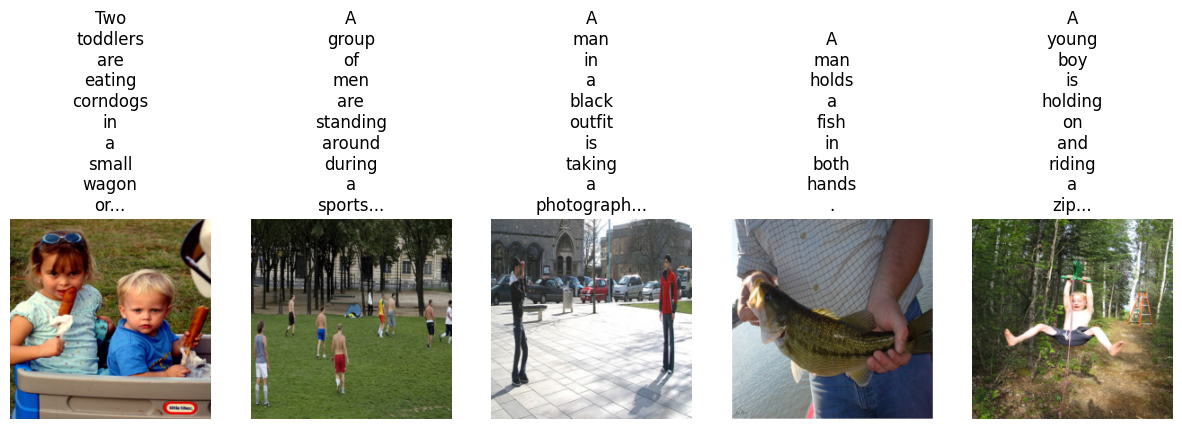

In [21]:
show_sample_images(dataset)

In [22]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [24]:
model = ImageCaptioning(embed_size, hidden_size, len(vocab.itos)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


Epoch 1/10: 100%|██████████| 1138/1138 [05:28<00:00,  3.46it/s]


Epoch 1: Train Loss = 3.1733, Val Loss = 2.6734


Epoch 2/10: 100%|██████████| 1138/1138 [04:36<00:00,  4.12it/s]


Epoch 2: Train Loss = 2.5176, Val Loss = 2.4797


Epoch 3/10: 100%|██████████| 1138/1138 [04:35<00:00,  4.12it/s]


Epoch 3: Train Loss = 2.2664, Val Loss = 2.4098


Epoch 4/10: 100%|██████████| 1138/1138 [04:38<00:00,  4.09it/s]


Epoch 4: Train Loss = 2.0709, Val Loss = 2.3912


Epoch 5/10: 100%|██████████| 1138/1138 [04:39<00:00,  4.08it/s]


Epoch 5: Train Loss = 1.9015, Val Loss = 2.3844


Epoch 6/10: 100%|██████████| 1138/1138 [04:39<00:00,  4.07it/s]


Epoch 6: Train Loss = 1.7495, Val Loss = 2.4145


Epoch 7/10: 100%|██████████| 1138/1138 [04:38<00:00,  4.09it/s]


Epoch 7: Train Loss = 1.6141, Val Loss = 2.4416


Epoch 8/10: 100%|██████████| 1138/1138 [04:38<00:00,  4.09it/s]


Epoch 8: Train Loss = 1.4901, Val Loss = 2.4879


Epoch 9/10: 100%|██████████| 1138/1138 [04:35<00:00,  4.12it/s]


Epoch 9: Train Loss = 1.3821, Val Loss = 2.5437


Epoch 10/10: 100%|██████████| 1138/1138 [04:35<00:00,  4.12it/s]


Epoch 10: Train Loss = 1.2841, Val Loss = 2.5986


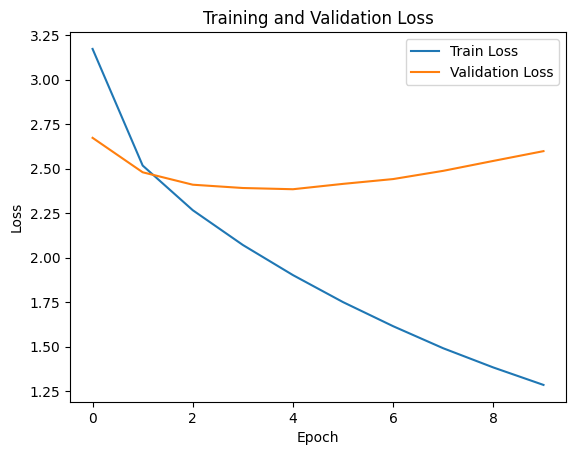

In [25]:
train(model, train_loader, criterion, optimizer, device, num_epochs, val_loader)

In [26]:
torch.save(model.state_dict(), "cnn_lstm_captioning_model.pth")
print("Training completed and model saved.")

Training completed and model saved.


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


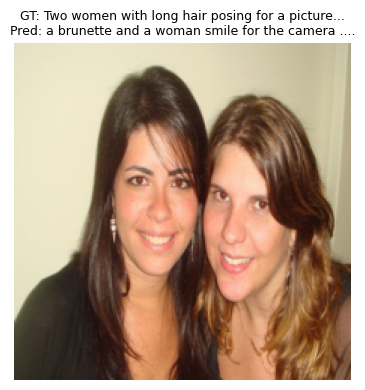

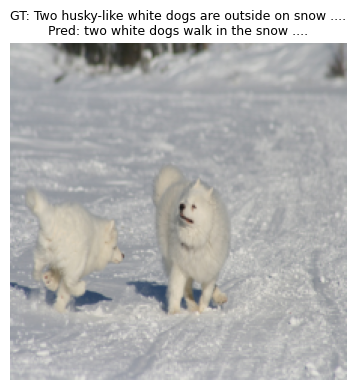

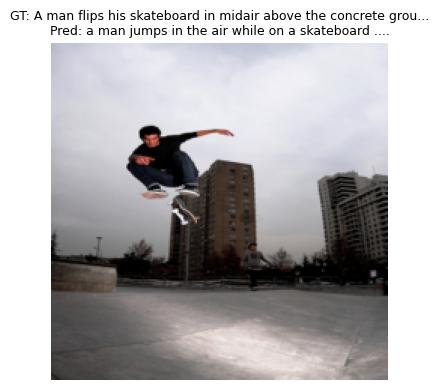

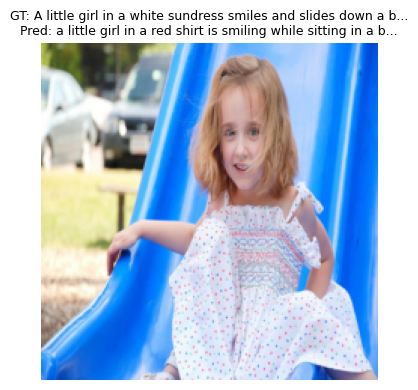

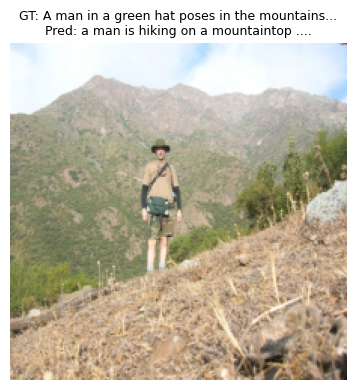

Average BLEU score: 0.2349


In [27]:
evaluate(model, val_loader, vocab)

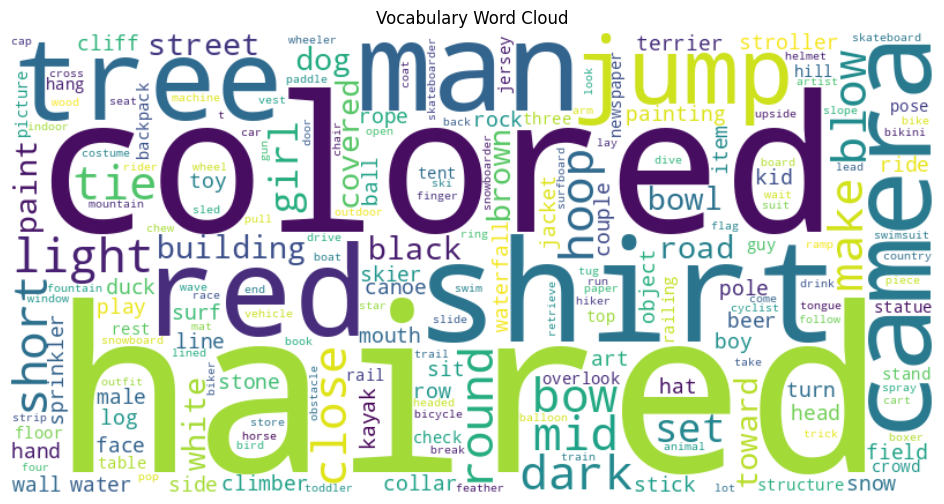

In [28]:
generate_word_cloud(vocab)